# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#7E8083   ; overflow:hidden"><b>Import libraries and load data</b></div>

In [91]:
import os
import pandas as pd 
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import root_mean_squared_error, r2_score
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [ ]:
dir = '../../data/predict/dataset'

def count_files_in_directory(directory):
    # 获取目录下的所有文件和文件夹
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file():
                df = pd.read_csv(entry)
                # df = df.drop(columns=['Target'])

                if 'tensor_list' not in locals():
                    tensor_list = df
                else:
                    tensor_list = pd.concat([tensor_list, df], ignore_index=True)


    return tensor_list



       Commit Count    Bot Commit  Modified File Count (Average)  \
count  11378.000000  11378.000000                   11378.000000   
mean      26.499648      0.697574                      13.322221   
std       46.018551      3.597783                     233.194131   
min        1.000000      0.000000                       1.000000   
25%        4.000000      0.000000                       1.538462   
50%       10.000000      0.000000                       2.709677   
75%       27.000000      0.000000                       5.484656   
max      726.000000    118.000000                   21878.000000   

       Created Issues  Closed Issues  Label Counts (Average)  Reopened Issues  \
count    11378.000000   11378.000000            11378.000000     11378.000000   
mean         8.333451       7.722623                0.409510         0.024433   
std         19.705993      21.372006                0.592061         0.418354   
min          0.000000       0.000000                0.000000   

# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#7E8083   ; overflow:hidden"><b>Data</b></div>

In [118]:
X_train = count_files_in_directory(dir)

data = X_train.copy().drop(columns=['Core Developers Focus Rate'])
data['Target'] = data['Target'].apply(lambda x: ast.literal_eval(x)[0] if x != '[]' else 0)
data['issue_delta'] = data['Created Issues'] - data['Closed Issues']
data['pr_delta'] = data['Created PRs'] - data['Closed PRs']
data['code_per_file'] = data['Code Lines'] / data['Code Files']
data['code_line_delta'] = data['Added Code Lines'] - data['Removed Code Lines']
data = data[0 < data['Develop Time']]
data = data[data['Develop Time'] < 5000]
data = data.drop(columns=['Markdown Files', 'Markdown Lines',
                          'Created Issues', 'Closed Issues', 
                          'Created PRs', 'Closed PRs', 
                          'Code Files', 'Code Lines', 'code_per_file',
                          'Added Code Lines', 'Removed Code Lines'])

# 
tar = data['Target']

data['Target'] = data.apply(lambda row: 1 if row['Target'] > row['Commit Count'] else 0, axis=1)

X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = pd.get_dummies(X_train, columns=['Target'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Target'], drop_first=True)

Y_train = X_train.pop('Target_1')
Y_test = X_test.pop('Target_1')



In [119]:
print(X_train.describe())


       Commit Count   Bot Commit  Modified File Count (Average)  \
count   8892.000000  8892.000000                    8892.000000   
mean      23.890576     0.733806                      13.970205   
std       42.371722     3.584808                     257.968072   
min        1.000000     0.000000                       1.000000   
25%        4.000000     0.000000                       1.500000   
50%       10.000000     0.000000                       2.697158   
75%       25.000000     0.000000                       5.468564   
max      726.000000   118.000000                   21878.000000   

       Label Counts (Average)  Reopened Issues    PR Length  Truck Factor  \
count             8892.000000      8892.000000  8892.000000   8892.000000   
mean                 0.463897         0.031826     5.643729      1.194220   
std                  0.632965         0.479942     5.703918      1.030498   
min                  0.000000         0.000000     0.000000      0.000000   
25%        

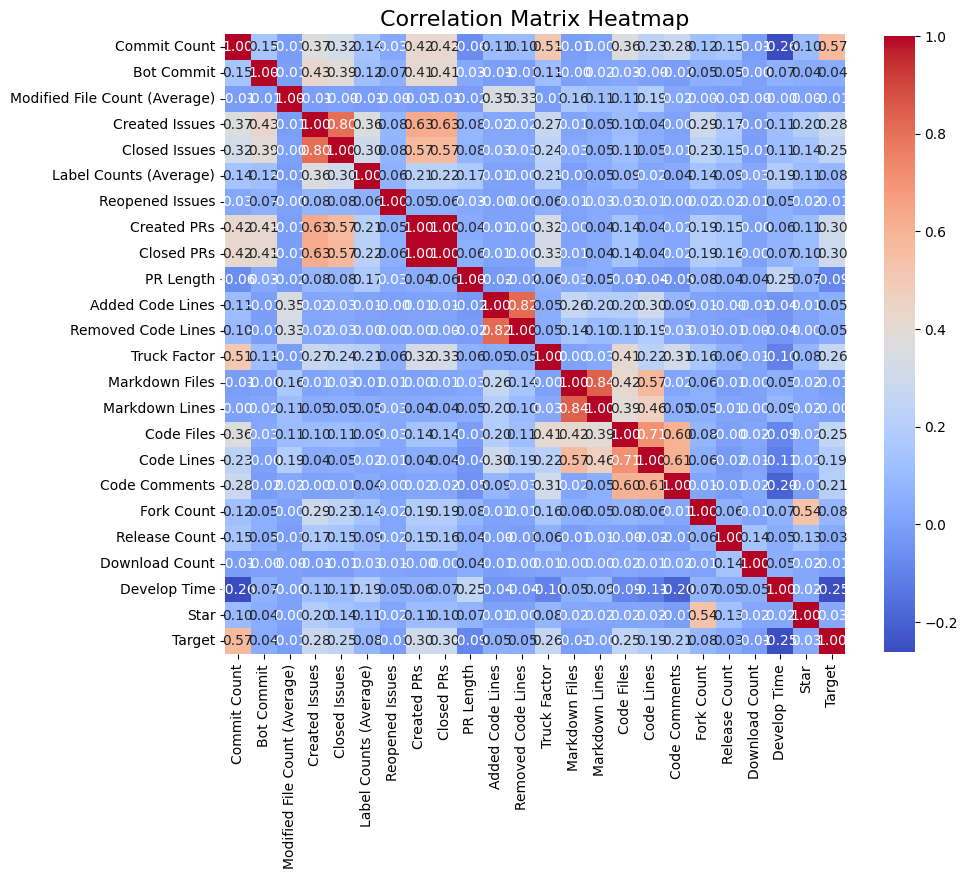

In [60]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# 添加标题
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

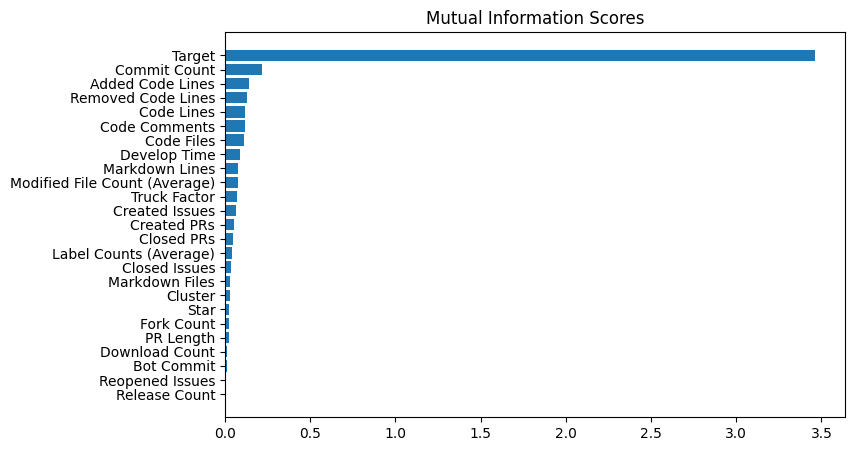

In [70]:
for colname in data.select_dtypes("object"):
    data[colname], _ = data[colname].factorize()
    
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(data, tar, False)
mi_scores[::3]  # show a few features with their MI scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [62]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4)
data["Cluster"] = kmeans.fit_predict(data)
data["Cluster"] = data["Cluster"].astype("category")

data.head()

,Commit Count,Bot Commit,Modified File Count (Average),Created Issues,Closed Issues,Label Counts (Average),Reopened Issues,Created PRs,Closed PRs,PR Length,...,Code Files,Code Lines,Code Comments,Fork Count,Release Count,Download Count,Develop Time,Star,Target,Cluster
0,33,0,1.060606,0,0,0.0,0,0,0,0.0,...,9,8361,16,0,2,10,15,0,21,1
1,19,0,1.157895,0,0,0.0,0,0,0,0.0,...,0,3149,6,0,7,43,31,0,2,1
2,2,0,2.000000,0,0,0.0,0,0,0,0.0,...,11,8429,20,0,1,7,48,0,7,1
3,13,0,1.000000,0,0,0.0,0,0,0,0.0,...,-2,4278,2,0,1,13,81,0,5,1
4,2,0,3.000000,0,0,0.0,0,0,0,0.0,...,19,8858,58,0,0,0,97,0,3,1


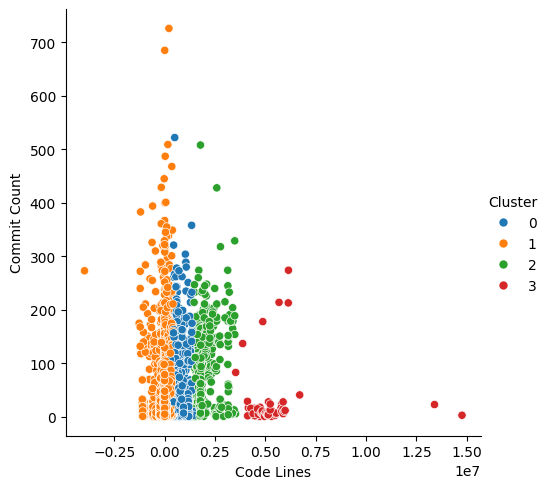

In [63]:
sns.relplot(
    x="Code Lines", y="Commit Count", hue="Cluster", data=data,
)

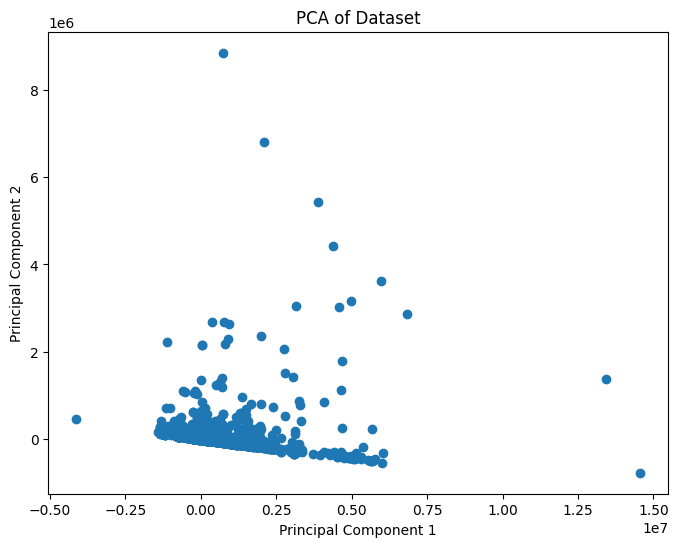

PC2    0.219956
PC1    0.211946
PC3    0.180080
PC4    0.178083
PC5    0.160392
Name: MI Scores, dtype: float64


KeyError: 'Target'

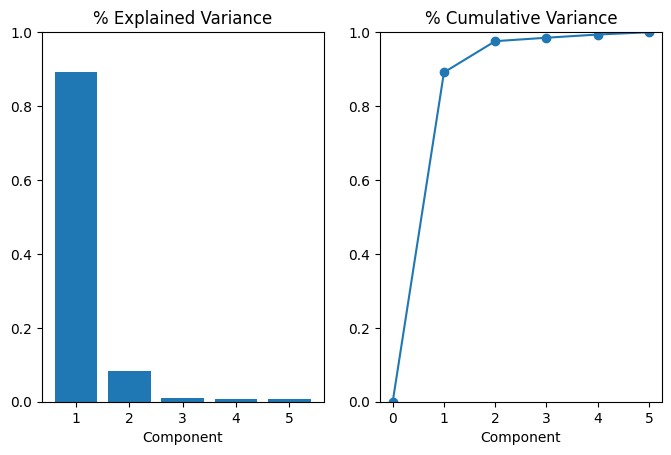

In [34]:
from sklearn.decomposition import PCA


pca = PCA(n_components=5)
principal_components = pca.fit_transform(data)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.show()

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


plot_variance(pca)

component_names = [f"PC{i+1}" for i in range(principal_components.shape[1])]
X_pca = pd.DataFrame(principal_components, columns=component_names)

mi_scores = make_mi_scores(X_pca, tar, discrete_features=False)
print(mi_scores)

sns.regplot(x="Commit Count", y='Target', data=data, order=2)

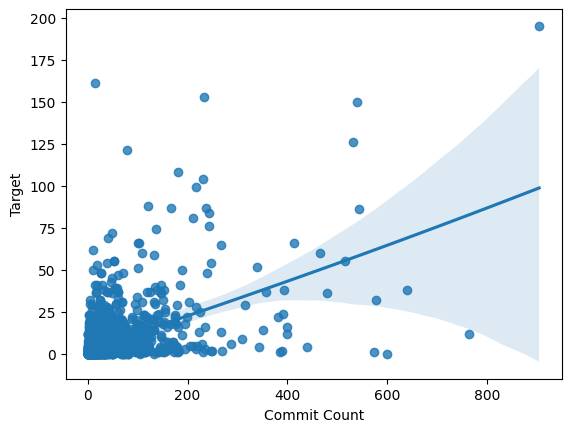

In [ ]:
sns.regplot(x="Commit Count", y='Target', data=data, order=2);

# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#7E8083   ; overflow:hidden"><b>Model</b></div>

In [95]:
Y_train.describe()

count      8892
unique        2
top       False
freq       6331
Name: Target_1, dtype: object

In [120]:
from sklearn.metrics import mean_squared_error

model = HyperoptEstimator(regressor=any_regressor('cla'), 
                          preprocessing=any_preprocessing('pre'),
                        #   loss_fn=mean_squared_error, 
                          algo=tpe.suggest, max_evals=50, trial_timeout=30)
# perform the search
model.fit(X_train, Y_train)
# summarize performance
mae = model.score(X_test, Y_test)
print("MAE: %.3f" % mae)
# summarize the best model
print(model.best_model())

  0%|          | 0/1 [00:06<?, ?trial/s, best loss=?]


RuntimeError: All trials failed or timed out. 
Result of last trial: {'status': 'new'}

In [121]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

y_pred_i = model.predict(X_train)
base = Y_train.iloc[::]
pred = y_pred_i[::]
accuracy = (base == pred).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


Accuracy: 0.7184


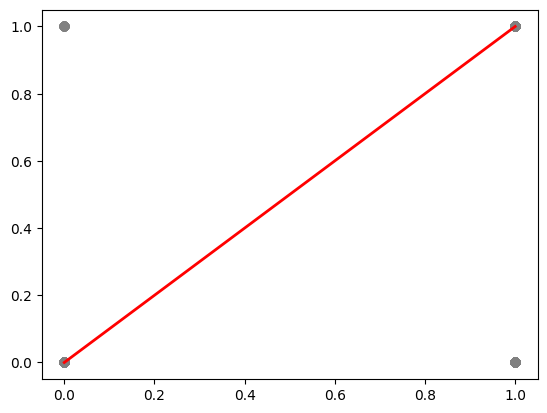

In [122]:
y_pred_i = model.predict(X_test)
base = Y_test.iloc[::]
pred = y_pred_i[::]
accuracy = (base == pred).mean()
print(f"Accuracy: {accuracy:.4f}")


plt.scatter(base, pred, color='grey', alpha=0.6)
plt.plot([base.min(), base.max()], [base.min(), base.max()], color='red', lw=2)
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import Normalizer


models = []
predictions = []
Y_test_list = []

# 循环训练count个模型
for i in range(count):
    # 获取第 i 个目标
    Y_train_i = Y_train[:, i]

    Y_test_i = Y_test[:, i]
    Y_test_list.append(Y_test_i)
    
    y_pred_i = model.predict(X_test)
    predictions.append(y_pred_i)

    # 输出每个模型的性能

    mse = root_mean_squared_error(Y_test_i, y_pred_i)
    print(f"Model {i + 1} Mean Squared Error: {mse:.4f}")

ValueError: Expected 2D array, got 1D array instead:
array=[  1.   4.   2.   1.   2.   1.   3.   1.  10.   4.   5.   4.   0.  12.
   1.   0.   1.   3.   0.   8.  11.   6.   2.   6.   1.   1.   0.   2.
   3.   2.   0.   7.   1.   1.   5.   1.   5.   4.   1.   2.   3.  63.
  43.  23.  30.  16.   2.   1.   1.  30.   1.   2.  20.   5.   1.   1.
   3.   5.   3.   8.   3.   2.  10.   9.   1.   5.  15.   1.  10.   2.
   3.   1.   2.   1.   4.   3.   9. 100.   1.  46.   5.   3.   5.   2.
  12.   3.   1.   1.   2.   2.   4.  24.  38.   6.   3.   1.   4.   5.
   2.   1.  30.   3.   0.   0.   5.   3.   2.   3.   3.   2.   2.   1.
   1.   3.   7.  46.   4.  39.   2.  14.   3.   1.   4.   1.   4.   2.
   0.   2.   1.   1.  18.   4.  14.   2.   4.   2.   1.   3.   4.   0.
   3.   2.  14.   6.   4.   1.  24.   2.   0.   1.   2.   2.   0.   1.
   3.   3.   2.   0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

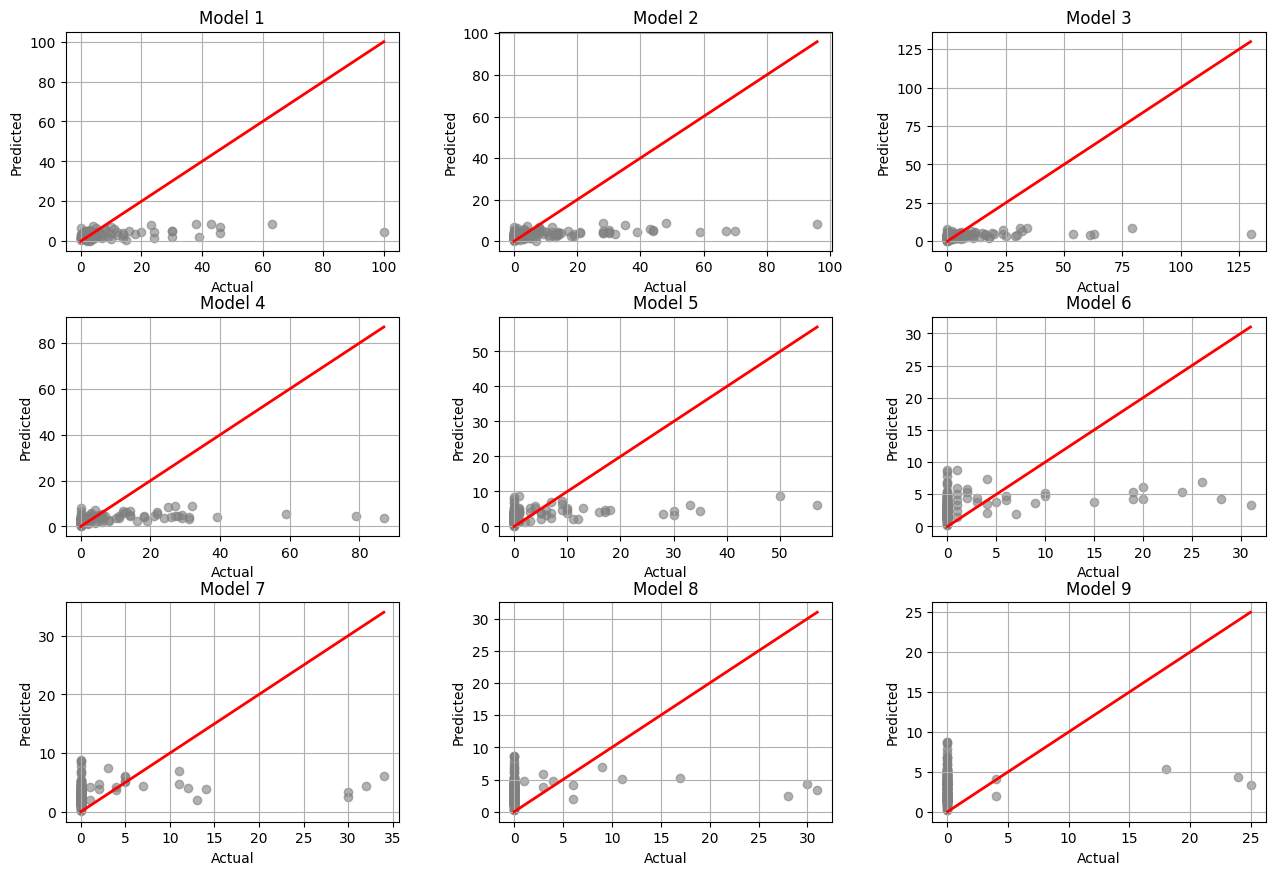

In [47]:
# 可视化所有count个模型的预测结果
plt.figure(figsize=(15, 10))

for i in range(count):
    plt.subplot(3, 3, i + 1)
    plt.scatter(Y_test_list[i], predictions[i], color='grey', alpha=0.6)
    plt.plot([Y_test_list[i].min(), Y_test_list[i].max()], [Y_test_list[i].min(), Y_test_list[i].max()], color='red', lw=2)
    plt.title(f'Model {i + 1}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid()

# 调整间距
plt.subplots_adjust(left=0.1, top=0.9, hspace=0.3, wspace=0.3)